In [ ]:
# Libraries and data setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

colors = {
    'precision': '#59A14F',
    'recall':    '#F28E2B',
    'f1_score':  '#4E79A7'
}

df_manual = pd.read_parquet(
    '../data/manual_predictions.parquet',
    columns=['id','rating']
    ).rename(
        columns={'rating':'rating_manual'}
    )
df_llm = pd.read_parquet(
    '../data/llm_predictions.parquet',
    columns=['id','model','rating','processing_time']
    ).rename(
        columns={'rating':'rating_llm'}
    )
df_comments = pd.read_parquet(
    '../data/comments.parquet',
    columns=['id','rating','comment_length_group','pros_length_proportion_group']
    ).rename(
        columns={'rating':'rating_real'}
    )

print(f"Comments manually predicted: {len(df_manual)}")
print(f"LLM predictions: {len(df_llm)}")
print(f"LLM models: {set(df_llm['model'])}")
print('\n')

df = (
    df_manual
    .merge(df_llm, on='id', how='left')
    .merge(df_comments, on='id', how='inner')
    )

for type in ['manual','llm']:
    df[f'is_inconsistent_{type}'] = (
        (df[f'rating_{type}'] - df['rating_real']).abs() > 1
        ).astype(int)

df.info()

Comments manually predicted: 402
LLM predictions: 73307
LLM models: {'llama2:7b', 'qwen3:1.7b', 'qwen3:4b', 'qwen2.5:0.5b', 'qwen2.5:3b', 'qwen2.5:1.5b', 'phi3:3.8b', 'gemma3:1b', 'gemma3:12b', 'stablelm2:12b', 'stablelm2:1.6b', 'deepseek-r1:1.5b', 'deepseek-r1:8b', 'llama3.1:8b', 'qwen3:8b', 'gemma3:4b', 'llama2:13b', 'qwen3:0.6b', 'llama3.2:3b'}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7422 entries, 0 to 7421
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            7422 non-null   object 
 1   rating_manual                 7422 non-null   int64  
 2   model                         7410 non-null   object 
 3   rating_llm                    7020 non-null   float64
 4   processing_time               7410 non-null   float64
 5   rating_real                   7422 non-null   int64  
 6   comment_length_group          7422 non-null   int64  
 7   pros_

In [ ]:
# model_metrics_df
y_true = df['is_inconsistent_manual']
y_pred = df['is_inconsistent_llm']

df = df.dropna(subset=['model'])

metrics = []
for model, group in df.groupby('model'):
    y_true = group['is_inconsistent_manual']
    y_pred = group['is_inconsistent_llm']

    metrics.append({
        'model': model,
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

model_metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

model_metrics_df['parameters'] = (
    model_metrics_df['model']
      .str.extract(r':([\d\.]+)b')[0]
      .astype(float)
)

mean_times = (
    df
    .groupby('model')['processing_time']
    .mean()
    .reset_index(name='avg_processing_time')
    .round(2)
)

model_metrics_df = model_metrics_df.merge(mean_times,on='model',how='left')

display(model_metrics_df.head())


,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,qwen3:4b,0.848718,0.585106,0.733333,0.650888,4.0,2.31
1,stablelm2:12b,0.869231,0.681818,0.600000,0.638298,12.0,83.74
2,llama2:7b,0.820513,0.523364,0.746667,0.615385,7.0,55.27
3,qwen3:8b,0.828205,0.546512,0.626667,0.583851,8.0,3.72
4,qwen2.5:0.5b,0.728205,0.407186,0.906667,0.561983,0.5,3.98


In [ ]:
# Model groups
small_3 = model_metrics_df.nsmallest(3, 'parameters')['model'].tolist()
small_5 = model_metrics_df.nsmallest(5, 'parameters')['model'].tolist()
big_3   = model_metrics_df.nlargest(3,  'parameters')['model'].tolist()
big_5   = model_metrics_df.nlargest(5,  'parameters')['model'].tolist()

fast_3 = model_metrics_df.nsmallest(3, 'avg_processing_time')['model'].tolist()
fast_5 = model_metrics_df.nsmallest(5, 'avg_processing_time')['model'].tolist()
slow_3 = model_metrics_df.nlargest(3,  'avg_processing_time')['model'].tolist()
slow_5 = model_metrics_df.nlargest(5,  'avg_processing_time')['model'].tolist()

groups = {
    'small_3': small_3,
    'small_5': small_5,
    'big_3':   big_3,
    'big_5':   big_5,
    'fast_3':  fast_3,
    'fast_5':  fast_5,
    'slow_3':  slow_3,
    'slow_5':  slow_5
}

for label, models in groups.items():
    print(f"{label:7}: {models}")

small_3: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b']
small_5: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b', 'deepseek-r1:1.5b', 'qwen2.5:1.5b']
big_3  : ['llama2:13b', 'stablelm2:12b', 'gemma3:12b']
big_5  : ['llama2:13b', 'stablelm2:12b', 'gemma3:12b', 'qwen3:8b', 'deepseek-r1:8b']
fast_3 : ['llama2:13b', 'qwen3:0.6b', 'gemma3:1b']
fast_5 : ['llama2:13b', 'qwen3:0.6b', 'gemma3:1b', 'qwen3:1.7b', 'gemma3:4b']
slow_3 : ['stablelm2:12b', 'llama3.1:8b', 'deepseek-r1:8b']
slow_5 : ['stablelm2:12b', 'llama3.1:8b', 'deepseek-r1:8b', 'llama2:7b', 'qwen2.5:3b']


In [ ]:
# group_metrics_df
param_df = pd.DataFrame({
    'model': [m for modelos in groups.values() for m in modelos],
    'parameters': [float(m.split(':')[1].replace('b',''))
                   for modelos in groups.values() for m in modelos]
})

time_df = (
    df
    .groupby('model')['processing_time']
    .mean()
    .reset_index(name='avg_processing_time')
    .round(2)
)

group_models = pd.DataFrame([
    {'group': f'{g}_majority', 'model': m}
    for g, modelos in groups.items()
    for m in modelos
])

group_stats = (
    group_models
    .merge(param_df, on='model')
    .merge(time_df, on='model')
    .groupby('group')
    .agg(parameters=('parameters','sum'),
         avg_processing_time=('avg_processing_time','sum'))
    .reset_index()
)

metrics = []
manual = df[['id','is_inconsistent_manual']].drop_duplicates('id').set_index('id')

for group_name, modelos in groups.items():
    sub = df[df['model'].isin(modelos)].drop_duplicates(['id','model'])
    wide = (
        sub
        .pivot(index='id', columns='model', values='is_inconsistent_llm')
        .fillna(0).astype(int)
    )
    threshold = len(modelos) / 2
    y_pred = (wide.sum(axis=1) > threshold).astype(int)
    y_true = manual.loc[y_pred.index, 'is_inconsistent_manual']
    metrics.append({
        'group':     f'{group_name}_majority',
        'accuracy':  accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall':    recall_score(y_true, y_pred, zero_division=0),
        'f1_score':  f1_score(y_true, y_pred, zero_division=0)
    })

group_metrics_df = (
    pd.DataFrame(metrics)
      .sort_values('f1_score', ascending=False)
      .merge(group_stats, on='group', how='left')
      .rename(columns={'group':'model'})
      .reset_index(drop=True)
)

display(group_metrics_df.head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,slow_3_majority,0.887179,0.771930,0.586667,0.666667,88.0,638.20
1,slow_5_majority,0.884615,0.758621,0.586667,0.661654,98.0,718.34
2,small_5_majority,0.758974,0.424000,0.706667,0.530000,10.4,35.81
3,big_5_majority,0.858974,0.750000,0.400000,0.521739,156.0,532.44
4,big_3_majority,0.856410,0.952381,0.266667,0.416667,124.0,347.34


In [ ]:
# metrics_df (Models + Groups)
metrics_df = pd.concat([model_metrics_df, group_metrics_df])
metrics_df['parameter_efficiency'] = metrics_df['f1_score'] / metrics_df['parameters']
metrics_df['time_efficiency'] = metrics_df['f1_score'] / metrics_df['avg_processing_time']
display(metrics_df.head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time,parameter_efficiency,time_efficiency
0,qwen3:4b,0.848718,0.585106,0.733333,0.650888,4.0,2.31,0.162722,0.281770
1,stablelm2:12b,0.869231,0.681818,0.600000,0.638298,12.0,83.74,0.053191,0.007622
2,llama2:7b,0.820513,0.523364,0.746667,0.615385,7.0,55.27,0.087912,0.011134
3,qwen3:8b,0.828205,0.546512,0.626667,0.583851,8.0,3.72,0.072981,0.156949
4,qwen2.5:0.5b,0.728205,0.407186,0.906667,0.561983,0.5,3.98,1.123967,0.141202


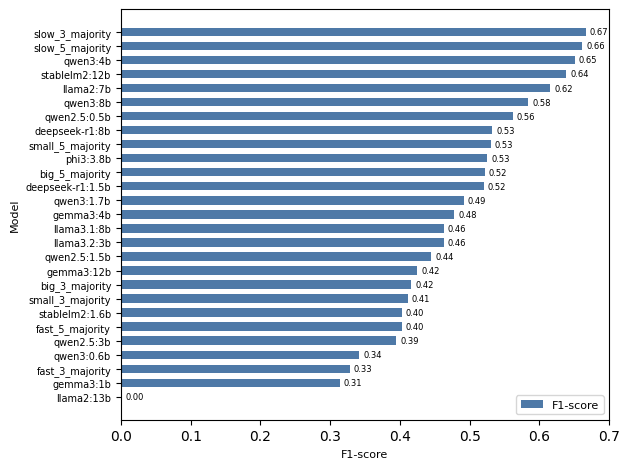

In [ ]:
# F1-Score Comparison
metrics_df = metrics_df.sort_values('f1_score', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['f1_score'], color=colors['f1_score'], height=bar_height, label='F1-score')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('F1-score', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


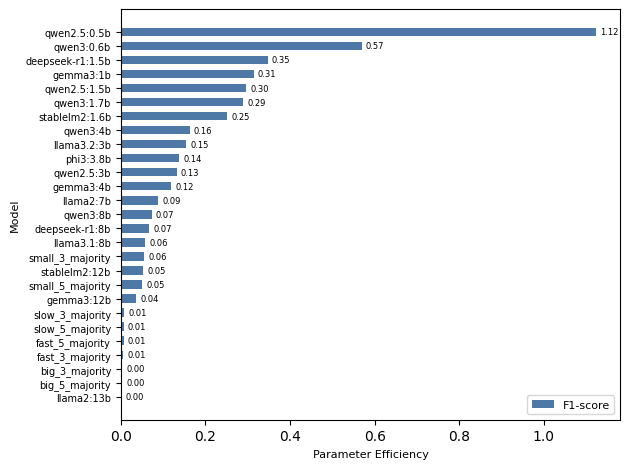

In [ ]:
# Parameter Efficiency Comparison
metrics_df = metrics_df.sort_values('parameter_efficiency', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['parameter_efficiency'], color=colors['f1_score'], height=bar_height, label='Parameter Efficiency')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('Parameter Efficiency', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


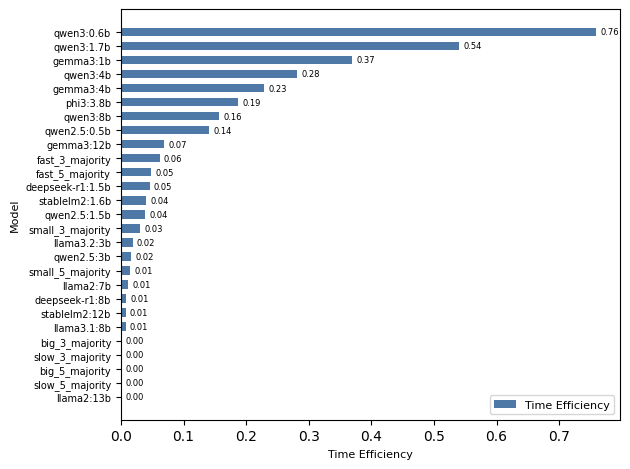

In [ ]:
# Time Efficiency Comparison
metrics_df = metrics_df.sort_values('time_efficiency', ascending=True)
models = metrics_df['model'].tolist()
y = np.arange(len(models))
bar_height = 0.6

fig, ax = plt.subplots()
bars_f1 = ax.barh(y, metrics_df['time_efficiency'], color=colors['f1_score'], height=bar_height, label='Time Efficiency')

ax.bar_label(bars_f1, fmt='%.2f', padding=3, fontsize=6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontsize=7)
ax.set_xlabel('Time Efficiency', fontsize=8)
ax.set_ylabel('Model', fontsize=8)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


- Comparar desempenho entre diferentes notas e tamanho de comentários